In this analysis, we will explore a dataset of google job ads. Those ads correspond either to the search string `machine learning engineer` or `data scientist`.

In [1]:
import os
import io
import re
import yaml

import pandas as pd
import numpy as np

from stemming import porter2

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn import set_config


import matplotlib as mlib
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage

In [2]:
set_config(display='diagram')

In [3]:
config_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'config.yaml'))
with open(config_path, 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.SafeLoader)

In [4]:
%matplotlib inline

In [31]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 180
plt.rcParams['figure.figsize'] = (10, 8)

In [6]:
client = storage.Client(config['project'])
bucket = client.get_bucket(config['bucket'])
blob = bucket.blob(config['dest_file'])
file_content = io.BytesIO(blob.download_as_string())

ads = pd.read_csv(file_content)

/Users/ruslan.kozhuharov/venvs/tf/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 7 columns):
id                  581 non-null object
job_descr           578 non-null object
location            552 non-null object
minimum_qual        578 non-null object
preferred_qual      578 non-null object
responsibilities    578 non-null object
title               581 non-null object
dtypes: object(7)
memory usage: 31.9+ KB


First, let us try using simple string operations to derive the additional information from the job title. Such information could be: seniority, function, etc.

In [8]:
ads.fillna('unknown', inplace=True)

In [9]:
def split_title(df):
    df[['role', 'department', 'area', 'other']] = df.title.str.split(',', expand=True)
    return df


def get_seniority(df):
    seniority_re = r'.*(intern|senior|lead|staff|principal|manager|head).*'
    seniority_normal = 'l3-l4'
    seniority_mapping = {'intern': 1,
                         seniority_normal: 3,
                         'senior': 5,
                         'lead': 6,
                         'staff': 7,
                         'principal': 8,
                         'manager': 9,
                         'head': 10}
    
    df['seniority'] = df.role.str.extract(pat=seniority_re, flags=re.I).fillna(seniority_normal)[0].str.lower()
    df['seniority_rank'] = df.seniority.map(seniority_mapping)
    return df


def get_function(df):
    function_re = r'.*(engineer|scientist|science|consultant|architect|advocate|developer|analyst|specialist).*'
    df['function'] = (df.role.str.extract(pat=function_re, flags=re.I)[0]
                      .str.lower().str.replace('science', 'scientist', flags=re.I))
    return df

In [10]:
ads = split_title(ads)
ads = get_seniority(ads)
ads = get_function(ads)

In [11]:
ads[['title', 'role', 'department', 'area', 'seniority', 'seniority_rank', 'function']].head()

,title,role,department,area,seniority,seniority_rank,function
0,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
1,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
2,"Conversational AI Engineer, Google Cloud Profe...",Conversational AI Engineer,Google Cloud Professional Services,None,l3-l4,3,engineer
3,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
4,"Data Scientist, Engineering",Data Scientist,Engineering,None,l3-l4,3,scientist


An interesting insight could be to see the most relevant terms from the qualifications and responsibilities with regards to the function. This could give us an isight into the keywords that one should emphasize on in their resume.

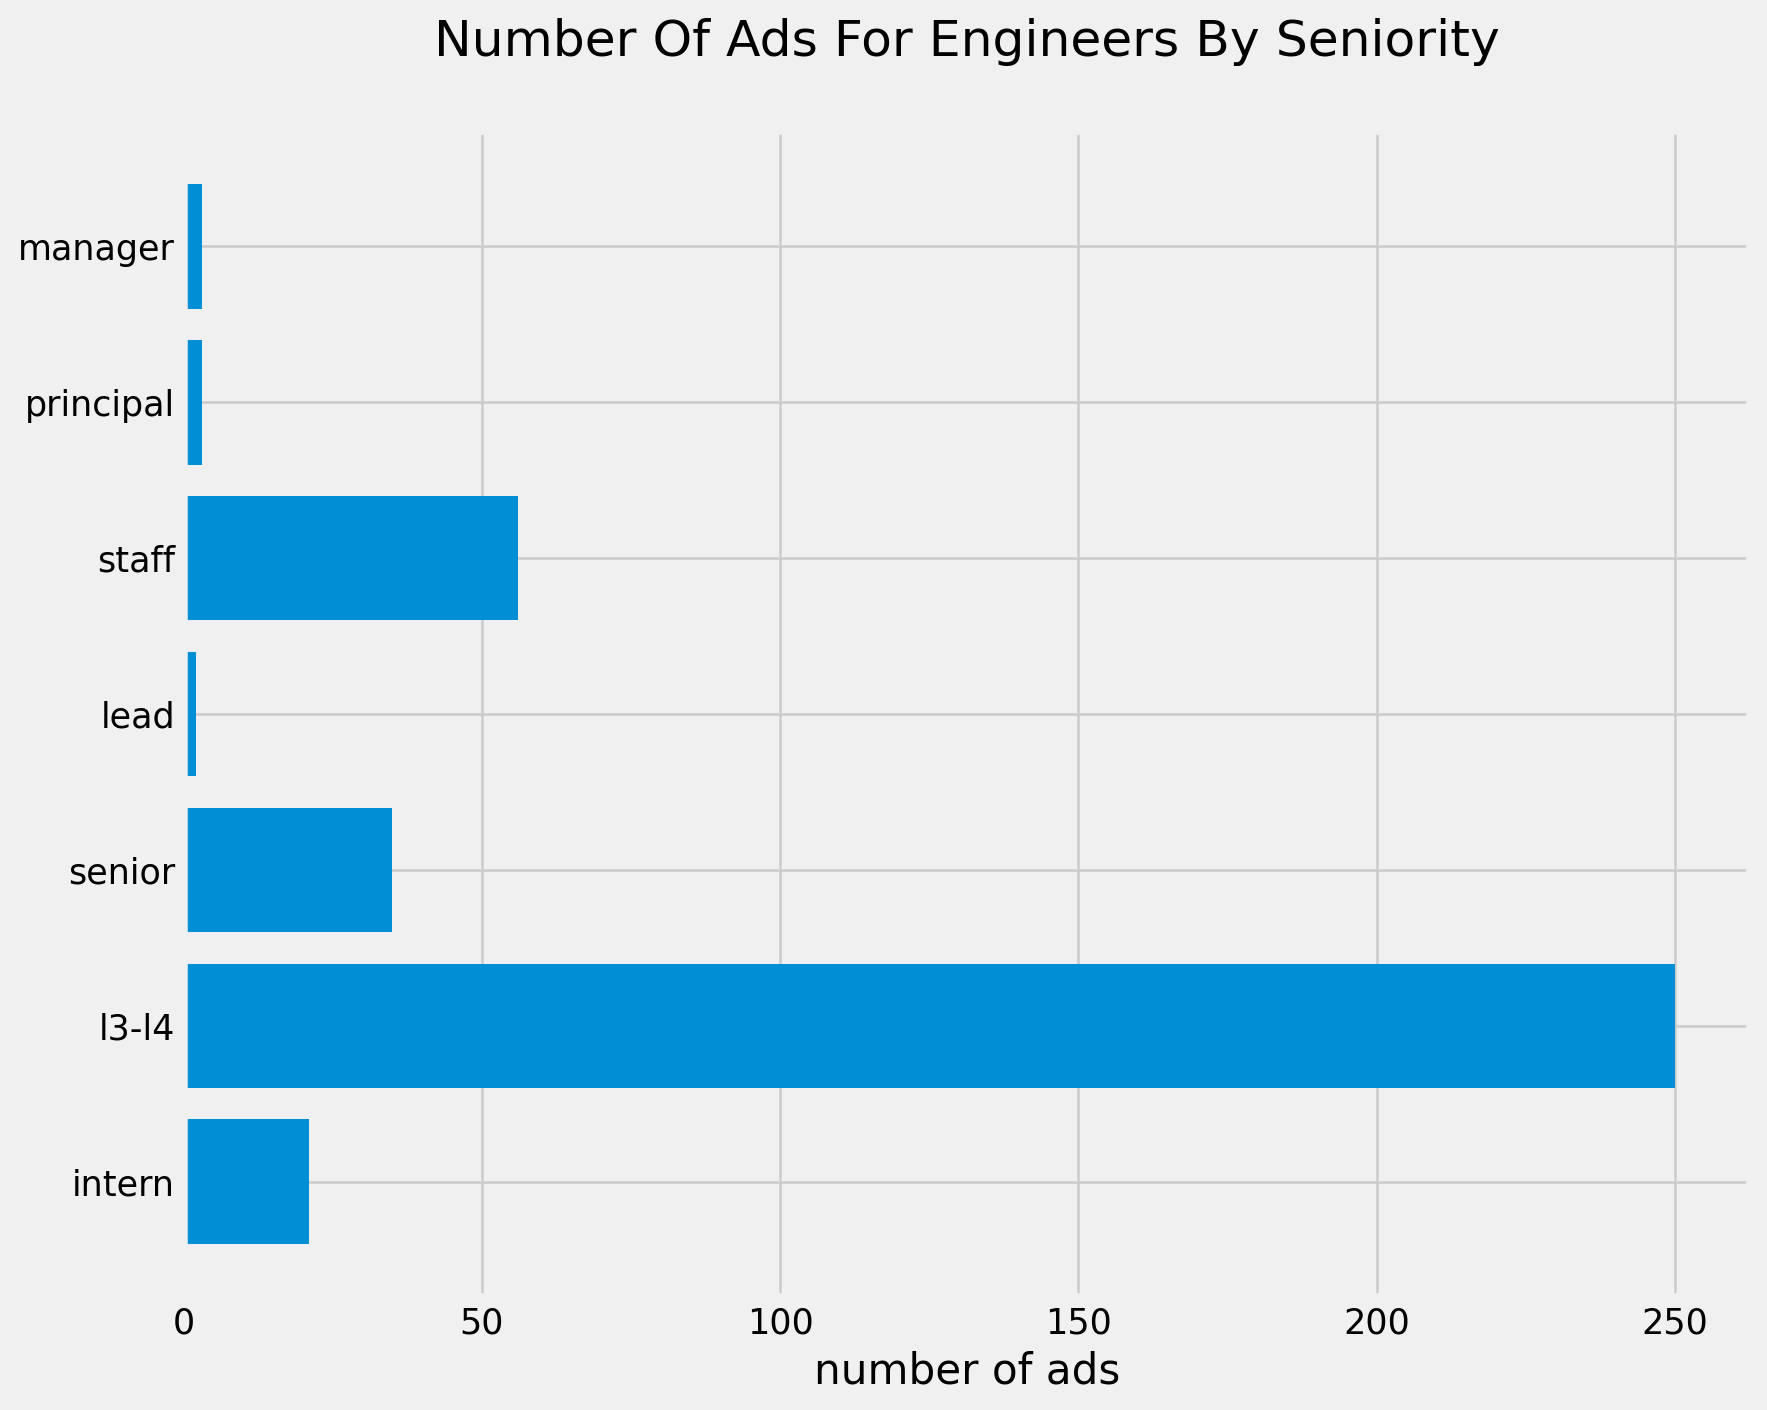

In [32]:
to_plot = (ads[ads.function=='engineer']
           .groupby(['seniority', 'seniority_rank'])
           .id.nunique().sort_index(level=1))

plt.barh(to_plot.index.get_level_values('seniority'), to_plot.values)
plt.xlabel('number of ads')
plt.title('Number Of Ads For Engineers By Seniority', pad=30)
plt.show()

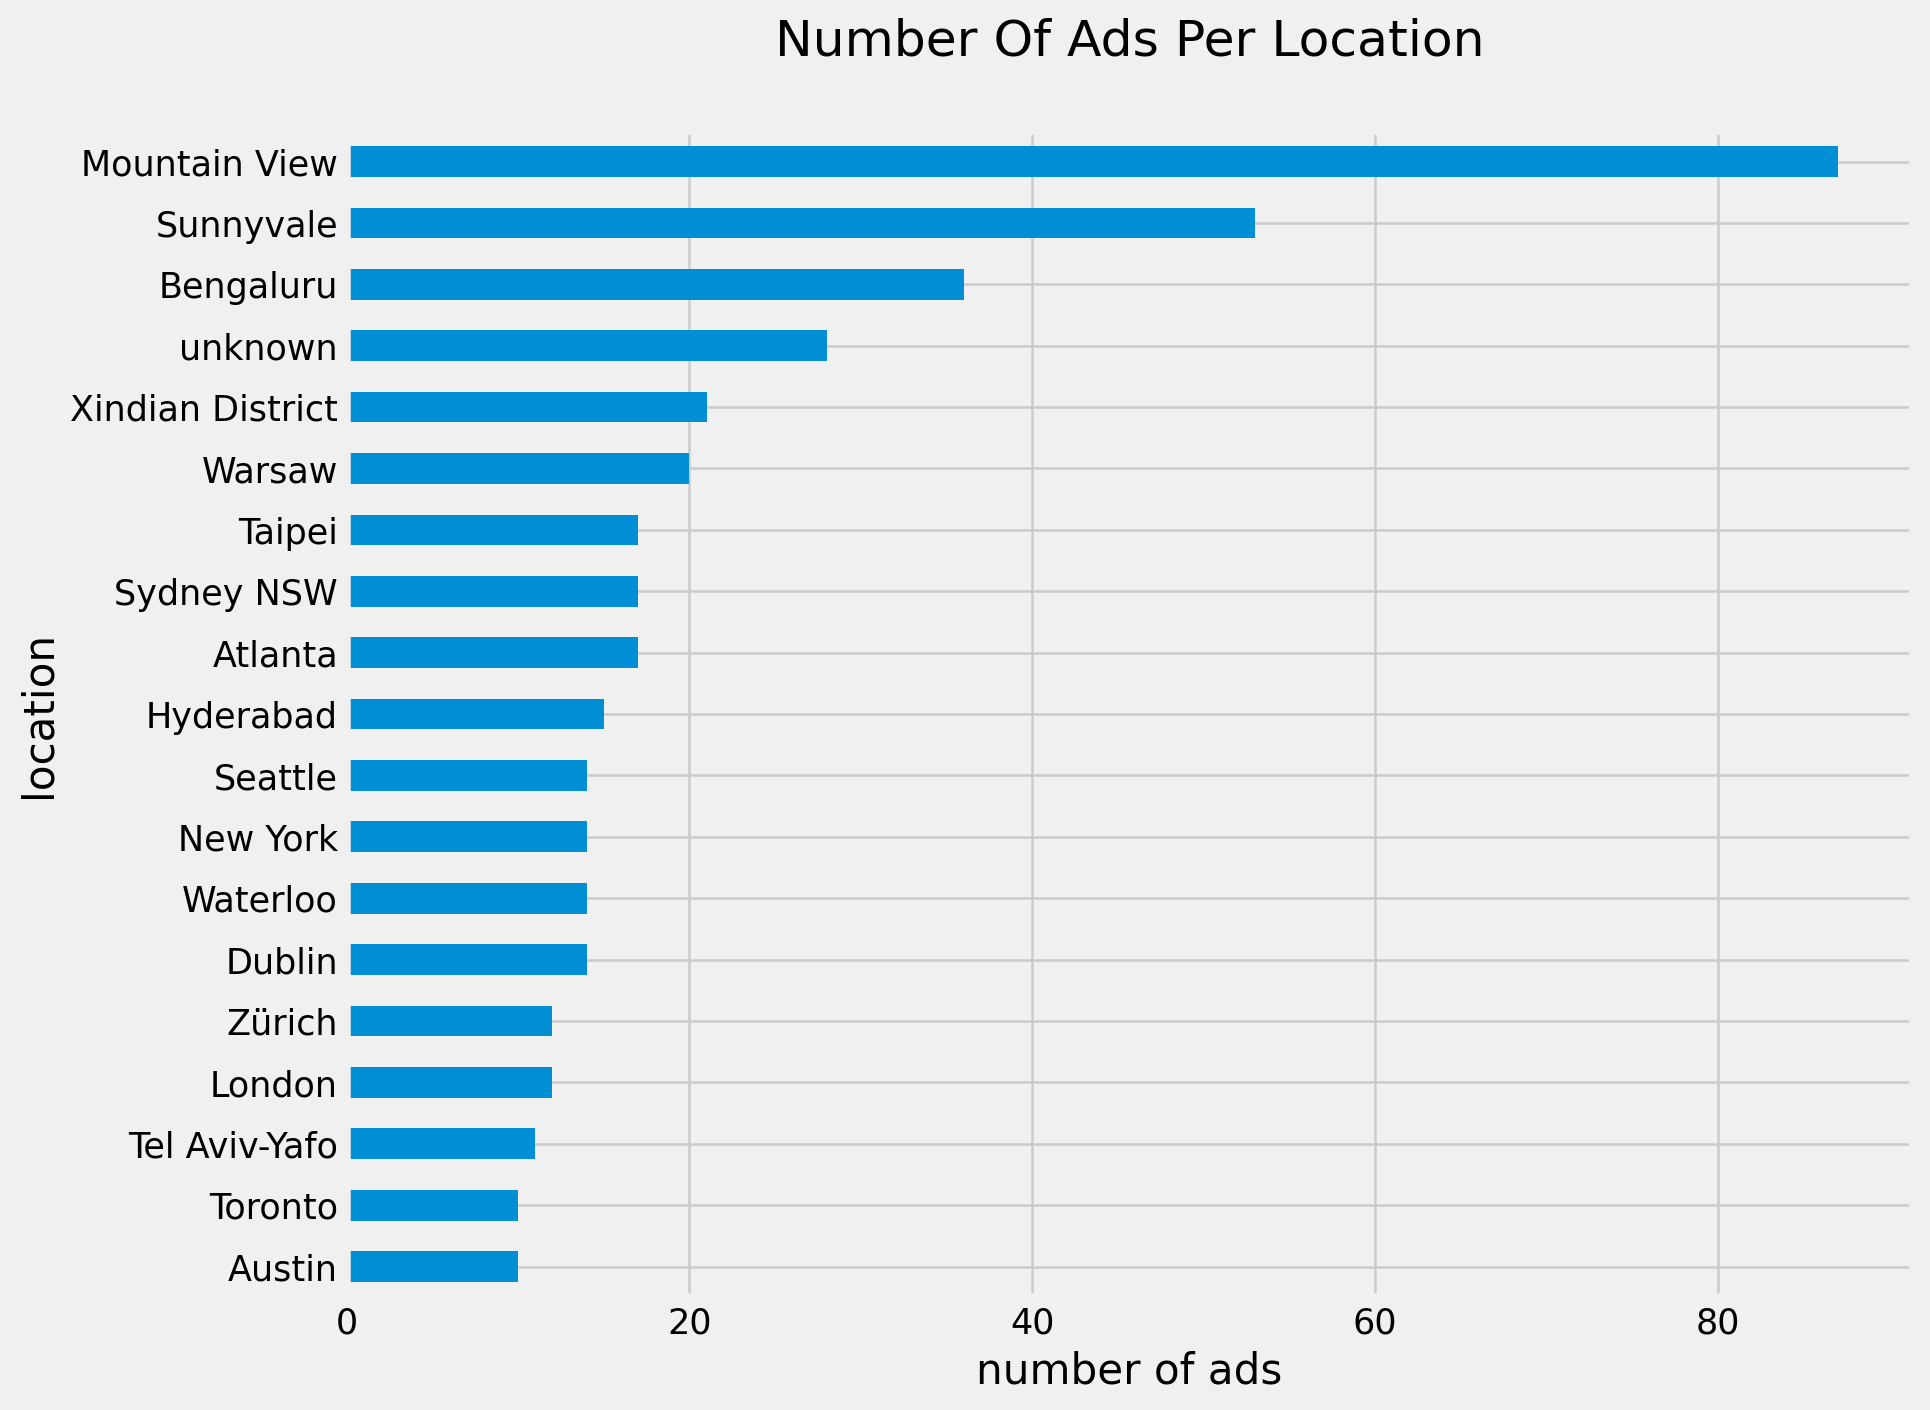

In [33]:
to_plot = ads.groupby('location').id.nunique()
to_plot[to_plot>=10].sort_values().plot.barh()
plt.xlabel('number of ads')
plt.title('Number Of Ads Per Location', pad=30)
plt.show()

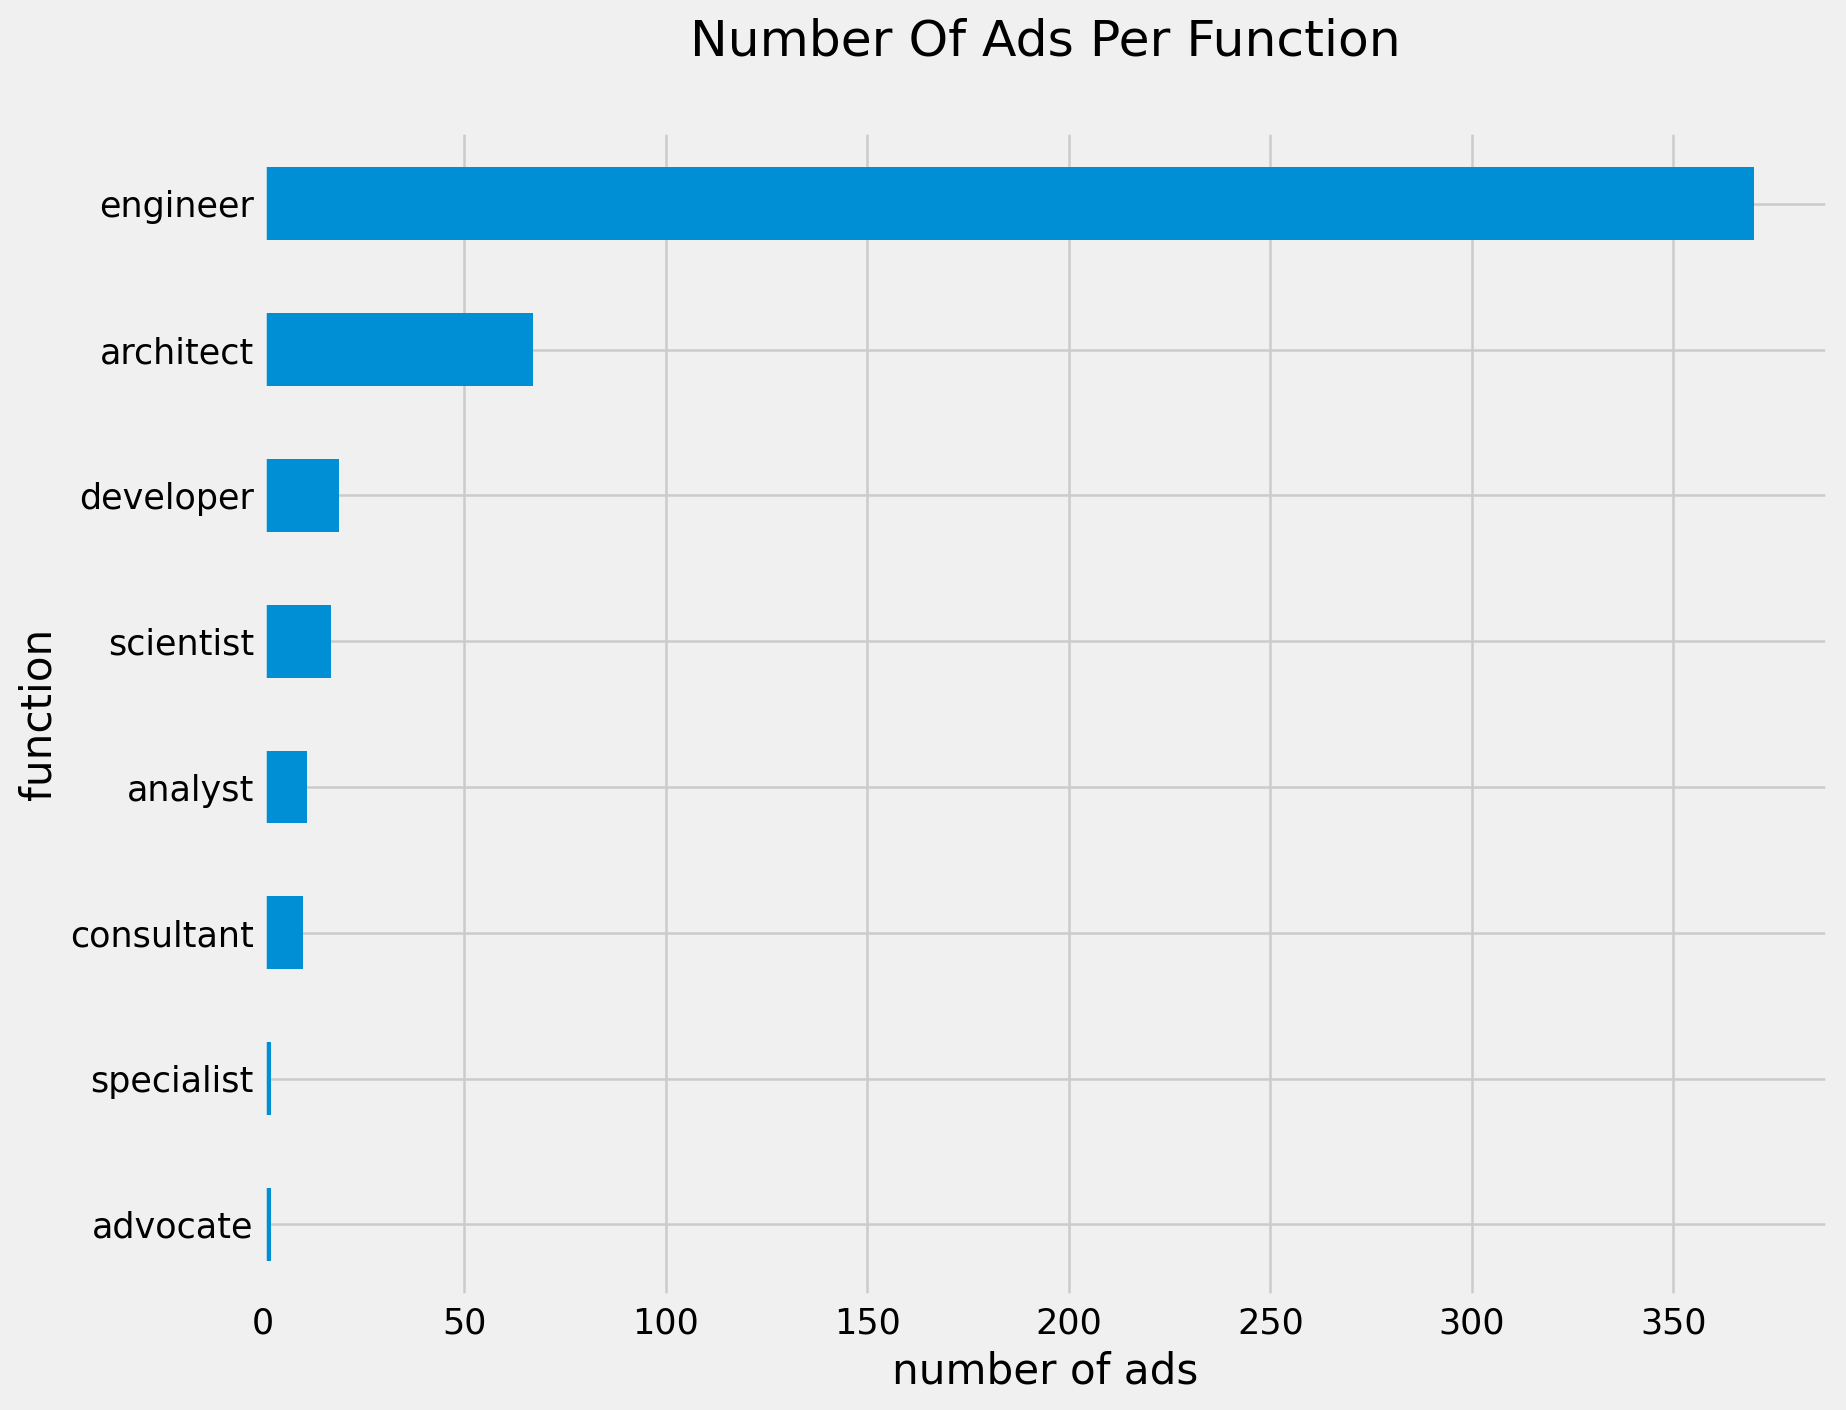

In [34]:
to_plot = ads.groupby('function').id.nunique()
to_plot.sort_values().plot.barh()
plt.xlabel('number of ads')
plt.title('Number Of Ads Per Function', pad=30)
plt.show()

In [15]:
location_counts = ads.location.value_counts()
functions_counts = ads.function.value_counts()

## Model On Function

In [16]:
min_n_ads_function = 20

conditions = (
    (ads.function.isin(functions_counts[functions_counts>=min_n_ads_function].index.to_list()))
    # & (ads.location.isin(location_counts[location_counts>=3].index.to_list()))
)

to_model = ads[conditions].copy()

In [17]:
label_enc = LabelEncoder()
to_model['function_enc'] = label_enc.fit_transform(to_model.function.astype('str'))

In [40]:
tfidf_params = {'stop_words': 'english',
                'ngram_range': (2, 5),
                'strip_accents': 'unicode'}

text_cols = ['job_descr', 'minimum_qual', 'preferred_qual', 'responsibilities']

prep_steps = []
prep_steps.extend([(f'tfidf_{c}', TfidfVectorizer(**tfidf_params), c) for c in text_cols])
# prep_steps.append(('loc_enc', OneHotEncoder(handle_unknown='ignore'), ['location']))

preprocess = ColumnTransformer(prep_steps)

multi_col_pipe = Pipeline([
    ('prep', preprocess),
    ('naive_bayes_clf', MultinomialNB())
])

In [41]:
X = to_model.drop('function_enc', axis=1)
y = to_model.function_enc

In [42]:
model = multi_col_pipe.fit(X, y)

In [43]:
model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf_job_descr',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'job_descr'),
                                                 ('tfidf_minimum_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'minimum_qual'),
                                                 ('tfidf_preferred_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'preferred_qual'),
                                                 ('tfidf_responsibilities',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'responsibilities')])),
                ('naive_bayes_clf', MultinomialNB())])

In [44]:
scores = cross_validate(model, X, y, cv=3, scoring='f1_weighted', return_train_score=True)

In [45]:
for k in scores.keys():
    print(f'{k}, mean: {scores[k].mean():.2f}, std: {scores[k].std():.2f}')

fit_time, mean: 0.61, std: 0.07
score_time, mean: 0.18, std: 0.01
test_score, mean: 0.90, std: 0.02
train_score, mean: 0.98, std: 0.00


In [46]:
steps = 100

lc_res = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, steps), scoring='f1_weighted', n_jobs=6, random_state=42)

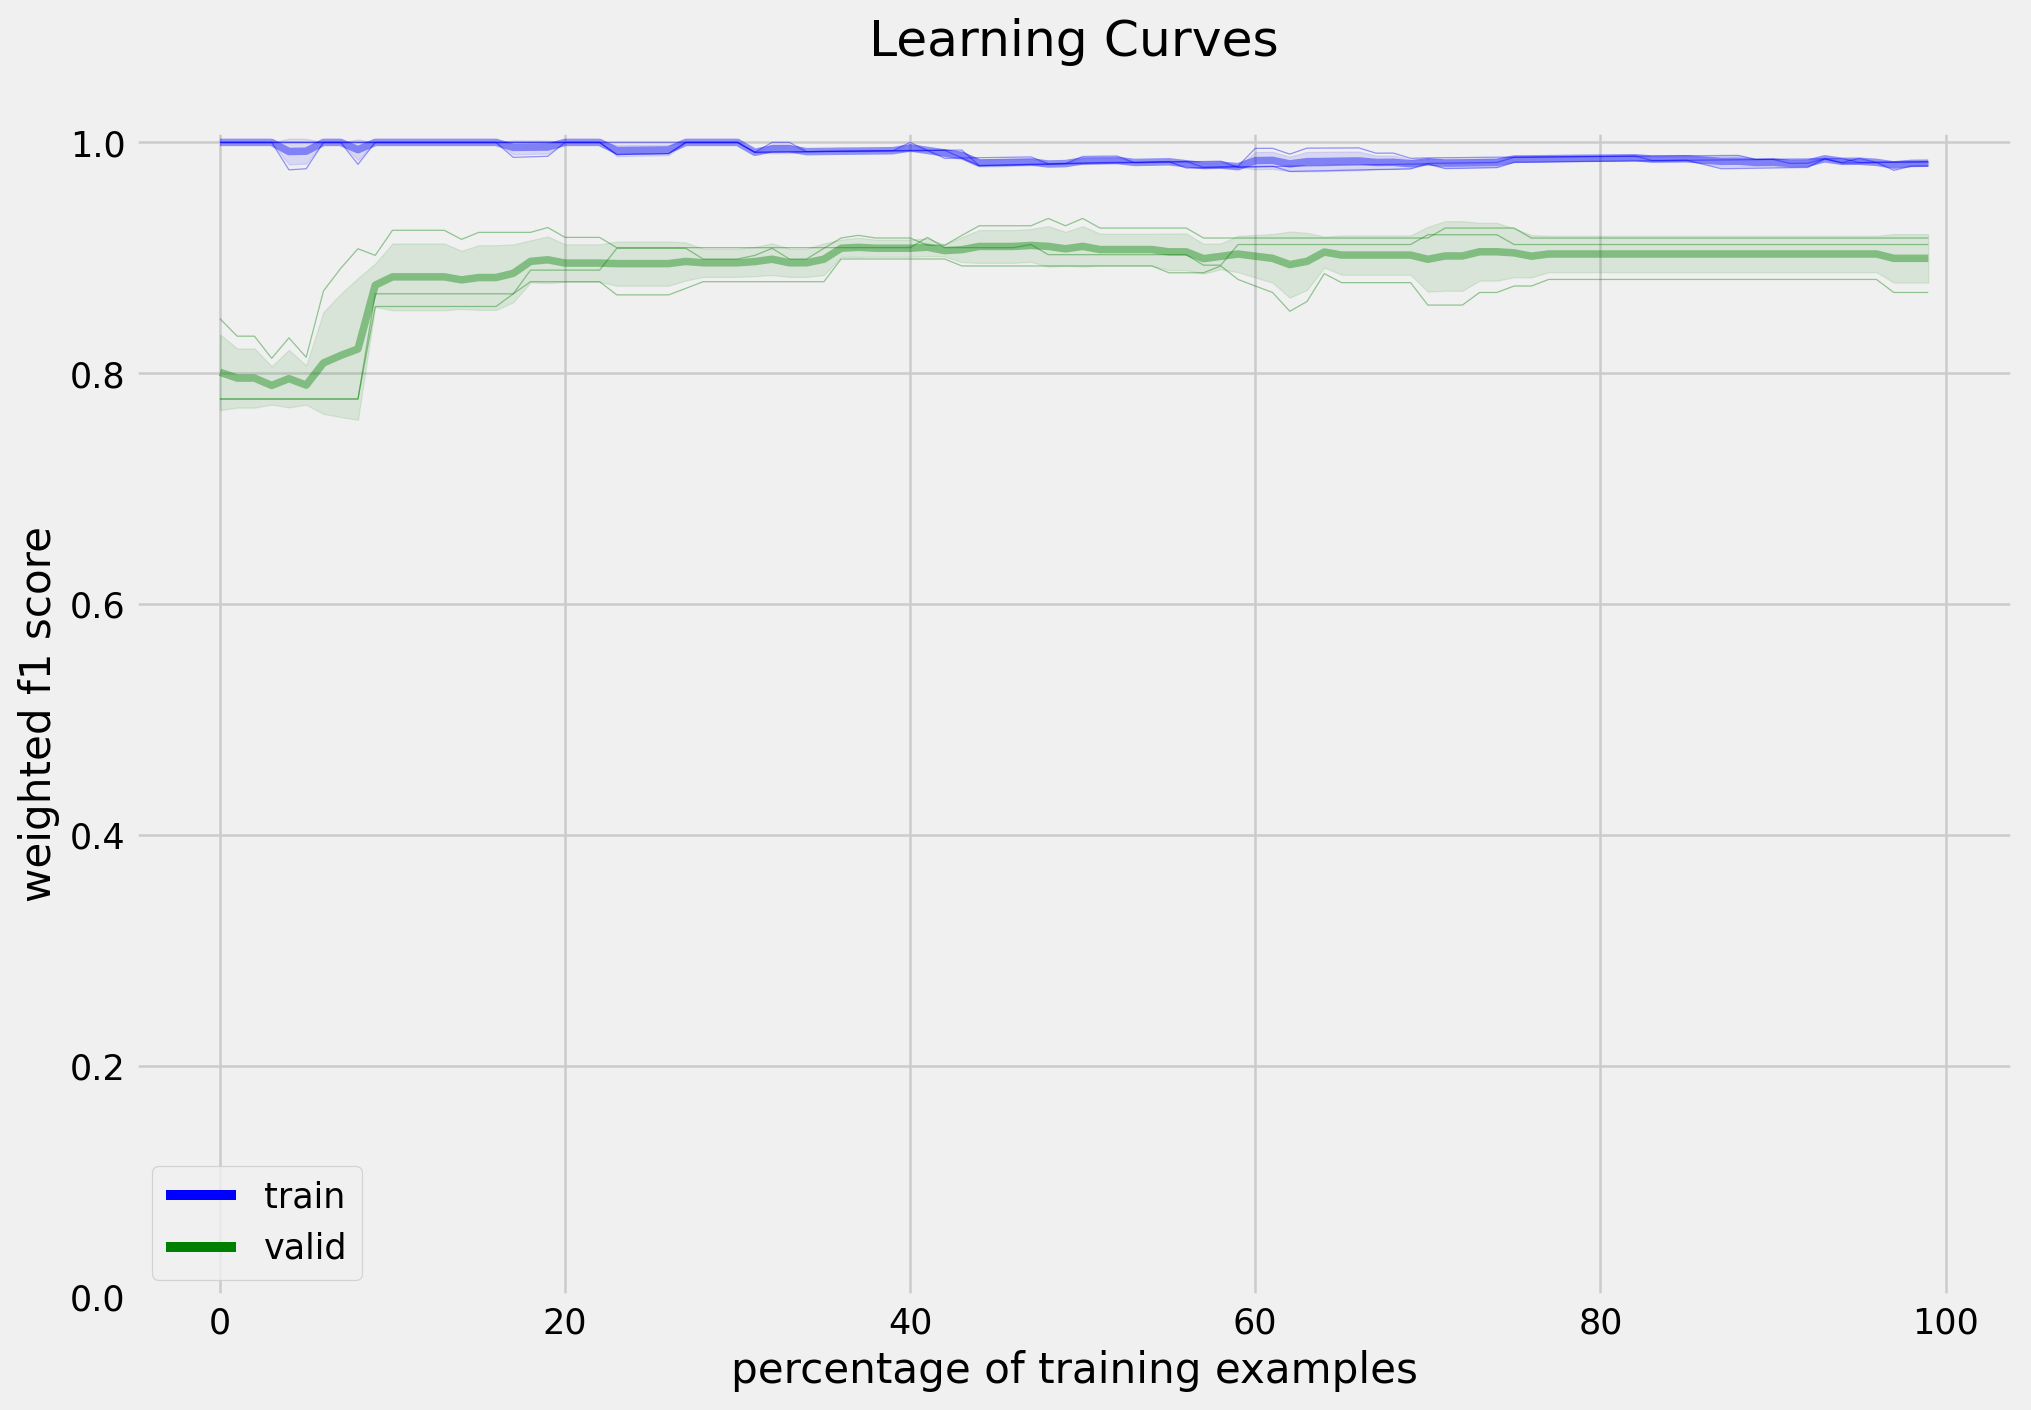

In [47]:
fig=plt.figure(figsize=(12, 8))

legend_handles = []

for i, c, l in zip([1, 2], ['b', 'g'], ['train', 'valid']):
    scores = lc_res[i]
    mean = np.mean(scores, axis=1)
    std = np.std(scores, axis=1)
    
    plt.fill_between(range(0, steps), mean-std, mean+std, color=c, alpha=0.1)
    plt.plot(mean, c=c, linewidth=3, alpha=0.4)
    legend_handles.append(mlib.lines.Line2D([], [], color=c, label=l))
    
    for j in range(3):
        plt.plot(scores[:, j], c=c, linewidth=0.5, alpha=0.4)

plt.ylim(0, 1.01)
plt.legend(handles=legend_handles)
plt.ylabel('weighted f1 score')
plt.xlabel('percentage of training examples')
plt.title('Learning Curves', pad=30)
plt.show()

In [48]:
importances_mcp = pd.DataFrame(model['naive_bayes_clf'].feature_log_prob_.transpose(),
                               columns=label_enc.classes_,
                               index=model['prep'].get_feature_names())

In [49]:
col_prefix = re.compile('(' + '|'.join([f'tfidf_{c}' for c in text_cols]) + ')(__)(.*)')

In [50]:
imp_terms = pd.DataFrame()

for l in label_enc.classes_:
    imp_scaled = pd.Series(MinMaxScaler().fit_transform(importances_mcp[l].values.reshape(-1, 1))[:,0], index=importances_mcp[l].index)
    imp_label = imp_scaled.sort_values(ascending=False)
    to_append = [{'feature': col_prefix.match(feature_term)[1],
                  'term': col_prefix.match(feature_term)[3],
                  'importance': imp,
                  'label': l}
                 for feature_term, imp in zip(imp_label.index, imp_label.values)]
    imp_terms = imp_terms.append(to_append, ignore_index=True)

In [56]:
(imp_terms[(imp_terms.label=='engineer')
           &(imp_terms.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
143633,tfidf_minimum_qual,software development,0.955495,engineer
143634,tfidf_minimum_qual,practical experience,0.932149,engineer
143635,tfidf_minimum_qual,bachelor degree,0.927300,engineer
143636,tfidf_minimum_qual,equivalent practical,0.926483,engineer
143637,tfidf_minimum_qual,equivalent practical experience,0.926483,engineer


In [59]:
(imp_terms[(imp_terms.label=='architect')
           &(imp_terms.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
1,tfidf_minimum_qual,cloud computing,0.877828,architect
2,tfidf_minimum_qual,experience cloud,0.675320,architect
4,tfidf_minimum_qual,years experience,0.624715,architect
5,tfidf_minimum_qual,10 years experience,0.616420,architect
6,tfidf_minimum_qual,experience customer,0.608197,architect


## Model On Location

In [60]:
min_n_ads_location = 20

conditions = (
    (ads.function=='engineer')
    & (ads.location.isin(location_counts[location_counts>=min_n_ads_location].index.to_list()))
)

to_model = ads[conditions].copy()

In [61]:
label_enc = LabelEncoder()
to_model['location_enc'] = label_enc.fit_transform(to_model.location.astype('str'))

In [67]:
to_model.location.value_counts()

Mountain View       66
Sunnyvale           34
Bengaluru           31
Xindian District    22
Warsaw              16
unknown             14
Atlanta             13
Name: location, dtype: int64

In [68]:
X = to_model.drop('location_enc', axis=1)
y = to_model.location_enc

In [71]:
model = multi_col_pipe.fit(X, y)

In [72]:
scores = cross_validate(model, X, y, cv=3, scoring='f1_weighted', return_train_score=True)

In [73]:
for k in scores.keys():
    print(f'{k}, mean: {scores[k].mean():.2f}, std: {scores[k].std():.2f}')

fit_time, mean: 0.31, std: 0.03
score_time, mean: 0.10, std: 0.00
test_score, mean: 0.43, std: 0.04
train_score, mean: 0.86, std: 0.05


In [74]:
importances_mcp = pd.DataFrame(model['naive_bayes_clf'].feature_log_prob_.transpose(),
                               columns=label_enc.classes_,
                               index=model['prep'].get_feature_names())

In [75]:
imp_terms = pd.DataFrame()

for l in label_enc.classes_:
    imp_scaled = pd.Series(MinMaxScaler().fit_transform(importances_mcp[l].values.reshape(-1, 1))[:,0], index=importances_mcp[l].index)
    imp_label = imp_scaled.sort_values(ascending=False)
    to_append = [{'feature': col_prefix.match(feature_term)[1],
                  'term': col_prefix.match(feature_term)[3],
                  'importance': imp,
                  'label': l}
                 for feature_term, imp in zip(imp_label.index, imp_label.values)]
    imp_terms = imp_terms.append(to_append, ignore_index=True)

In [77]:
(imp_terms[(imp_terms.label=='Mountain View')
           &(imp_terms.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
164330,tfidf_minimum_qual,development experience,1.000000,Mountain View
164331,tfidf_minimum_qual,software development experience,0.944761,Mountain View
164332,tfidf_minimum_qual,software development,0.939205,Mountain View
164333,tfidf_minimum_qual,experience years,0.902416,Mountain View
164334,tfidf_minimum_qual,advanced degree,0.865308,Mountain View


In [78]:
(imp_terms[(imp_terms.label=='Warsaw')
           &(imp_terms.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
328661,tfidf_minimum_qual,experience technical,0.571051,Warsaw
328663,tfidf_minimum_qual,practical experience experience,0.565411,Warsaw
328662,tfidf_minimum_qual,equivalent practical experience experience,0.565411,Warsaw
328665,tfidf_minimum_qual,experience experience,0.511969,Warsaw
328667,tfidf_minimum_qual,technical field,0.499810,Warsaw
